<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Executing Circuits on a Quantum Device

Previously we have performed basic operations on circuits, and ran those circuits on real quantum devices using the `execute` function.  Or goal here is to introduce what `execute` is doing behind the scenes in order to rewrite and optimize input circuits for the IBM Q quantum devices.

In [38]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit.tools.monitor import job_monitor
%matplotlib inline

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

## Introduction

Consider the following circuit that creates a five-qubit GHZ state:

In [47]:
ghz = QuantumCircuit(5, 5)
ghz.h(0)
for idx in range(1,5):
    ghz.cx(0,idx)
ghz.barrier(range(5))
ghz.measure(range(5), range(5))
ghz.draw()

In preparation for later comparisons, we also simulate the ideal output distrobution:

In [42]:
sim = Aer.get_backend('qasm_simulator')
job_sim = execute(ghz, sim)

We would like to take this circuit and run it on an IBM Q quantum device.  However, in its original form, this circuit cannot be run.  This circuit, as is the case with most circuits, must undergo a series of transformations that make it compatible with a given target device, and optimize it to reduce the effects of noise on the resulting outcomes.  In what follows we highlight the key steps in this workflow, and show how they can be modified by changing the value of keyword arguments passed to the `execute` function.


For those wishing to bypass this in-depth discussion of what happens during the execution process, we note that the standard way of calling the `execute` function is:

```python
job = execute(circuits, backend, optimization_level=1)
```

where `circuits` is a single or list of input circuits, `backend` is the target device, and `optimization_level` selects between four different `[0,1,2,3]` preset methods of circuit rewriting and optimization.  By default, `optimization_level=1`.

## Basis Gates

When writing a quantum circuit you are free to use any quantum gate (unitary operator) that you like, along with a collection of non-gate operations such as qubit measurements and reset operations.  However, when running a circuit on a real quantum device one no longer has this flexibility.  Due to limitations in, for example, the physical interactions between qubits, difficulty in implementing multi-qubit gates, control electronics etc, a quantum computing device can only natively support a handful of quantum gates and non-gate operations. In the present case of IBM Q devices, the native gate set can be found by querying the devices themselves, and looking for the corresponding attribute in their configuration:

In [13]:
provider = IBMQ.get_provider(group='open')
provider.backends(simulator=False)

[<IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [14]:
backend = provider.get_backend('ibmqx4')
backend.configuration().basis_gates

['u1', 'u2', 'u3', 'cx', 'id']

We see that the `ibmqx4` device supports five native gates: three single-qubit gates (`u1`, `u2`, `u3`, and `id`) and one two-qubit entangling gate `cx`.  In addition, the device supports qubit measurements (otherwise we can not read out an answer!).  Although we have queried only a single device, all IBM Q devices support this gate set.

The `u*` gates represent arbitrary single-qubit rotations of one, two, and three angles.  The `u1` gates are single-parameter rotations that represent generalized phase gates of the form

$$
U_{1}(\lambda) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\lambda}
\end{bmatrix}
$$

This set includes common gates such as $Z$, $T$, $T^{\dagger}$, $S$, and $S^{\dagger}$.  It turns out that these gates do not actually need to be performed on hardware, but instead, can be implemented in software as "virtual gates".  These virtual gates are called "frame changes" and take zero time, and have no associated error; they are free gates on hardware.

Two-angle rotations, $U_{2}(\phi,\lambda)$, are actually two frame changes with a single $X_{\pi/2}$ gate in between them, and can be used to synthesize gates like the Hadamard ($U_{2}(0,\pi)$) gate.  As the only actual gate performed is the $X_{\pi/2}$ gate, the error and gate time associated with any $U_{2}$ gate is the same as an $X_{\pi/2}$ gate.  Similarly, $U_{3}(\theta,\phi,\lambda)$ gates are formed from three frame changes with two $X_{\pi/2}$ gates in between them.  The errors and gate times are twice those of a single $X_{\pi/2}$.  The identity gate, $id$, is straightforward, and is a placeholder gate with a fixed time-interval. 

The only entangling gate supported by the IBM Q devices is the CNOT gate (`cx`) that, in the computational basis, can be written as:

$$
\mathrm{CNOT}(0,1) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$,

where we see that the matrix form follows from the specific bit-ordering convention used in Qiskit.

Every quantum circuit run on a IBM Q device must be expressed using only these basis gates.  For example, suppose one wants to run a simple phase estimation circuit:

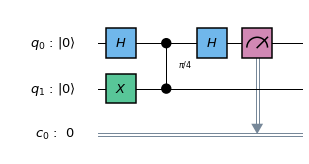

In [25]:
qc = QuantumCircuit(2, 1)

qc.h(0)
qc.x(1)
qc.cu1(np.pi/4, 0, 1)
qc.h(0)
qc.measure([0], [0])
qc.draw(output='mpl')

We have $H$, $X$, and controlled-$U_{1}$ gates, all of which are not in our devices basis gate set, and must be expanded.  This expansion is taken care of for us in the `execute` function.  However, we can decompose the circuit to show what it would look like in the native gate set of the IBM Q devices

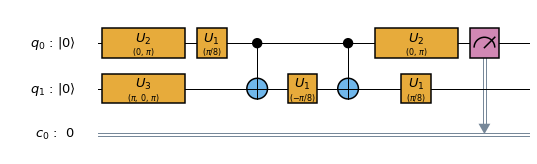

In [24]:
qc_basis = qc.decompose()
qc_basis.draw(output='mpl')

As we have already see in part 3 of this introduction, circuits rewritten for actual devices grow in size, as measured by the depth of the circuit

In [27]:
print(qc.depth(), ',', qc_basis.depth())

4 , 7


It is possible to pass a custom list of basis gates to `execute` using the `basis_gates` keyword argument.  However, the resulting circuits will fail on real devices, and such functionality is only supported on simulator backends.

## Initial Layout

Quantum circuits are abstract entities whose qubits are "virtual" representations of actual qubits used in computations.  We need to be able to map these virtual qubits in a one-to-one manner to the "physical" qubits in an actual quantum device.

<img src="./images/mapping.png" width=800px>

By default, qiskit will do this mapping for you.  The choice of mapping depends on the properties of the circuit, the particular device you are targeting, and the optimization level that is chosen.  The basic mapping strategies are the following:

- **Trivial layout**: Map virtual qubits to the same numbered physical qubit on the device (default in `optimization_level=0`).


- **Dense layout**: Find the sub-graph of the device with same number of qubits as the circuit with the greatest connectivity (default in `optimization_level=1`).


- **Noise adaptive layout**: Uses the noise properties of the device, in concert with the circuit properties, to generate the layout with the best noise properties (default in `optimization_level=2` and `optimization_level=3`).

The choice of initial layout is extremely important when computing the number of SWAP operations needed to map the input circuit onto the device topology.

### Specifying an Initial Layout

It is completely possible to specify your own initial layout.  To do so we can pass a list of integers to `execute` via the `initial_layout` keyword argument, where the index labels the virtual qubit in the circuit and the corresponding value is the label for the physical qubit to map onto.  For example, lets map our GHZ circuit onto `ibmq_16_melbourne` in two different ways and check the results against the ideal simulation results:

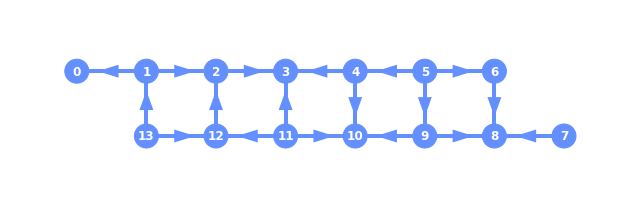

In [32]:
backend = provider.get_backend('ibmq_16_melbourne')
plot_gate_map(backend, plot_directed=True)

In [36]:
# Virtual -> physical
#    0    ->    11
#    1    ->    12
#    2    ->    10
#    3    ->    2
#    4    ->    4

job1 = execute(ghz, backend, initial_layout=[11,12,10,2,4])
job_monitor(job1)

Job Status: job has successfully run


In [37]:
# Virtual -> physical
#    0    ->    0
#    1    ->    6
#    2    ->    10
#    3    ->    13
#    4    ->    7

job2 = execute(ghz, backend, initial_layout=[0,6,10,13,7])
job_monitor(job2)

Job Status: job has successfully run


In [43]:
counts_sim = job_sim.result().get_counts()
counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()

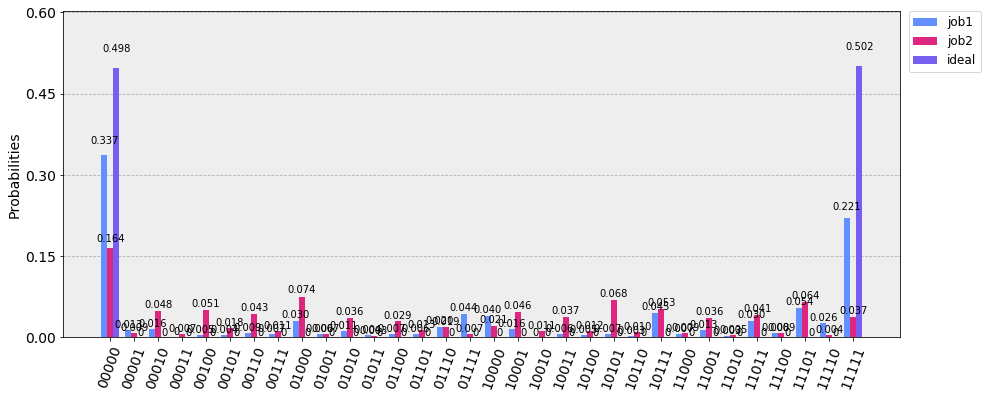

In [46]:
plot_histogram([counts1, counts2, counts_sim],
               figsize=(15,6),
               legend=['job1', 'job2', 'ideal'])

From the figure it is clear that the choice of initial layout is an extremely important step, and can mean the difference between a good answer and one dominated by noise.  The next section will tell us why.

## Mapping Circuits to Hardware Topology

Our GHZ circuit consists of a single qubit (`0`) coupled to the others via CNOT gates.  If implemented directly, this would require hardware that has a single qubit coupled to four other qubits.  Looking at the gate maps of the public IBM Q hardware we see that there are two devices that fit this description.

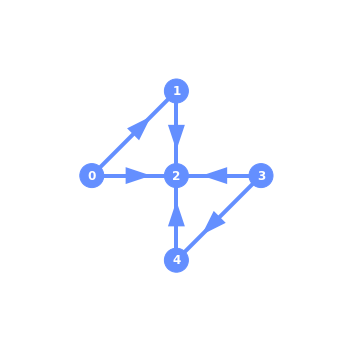

In [51]:
backend = provider.get_backend('ibmqx2')
plot_gate_map(backend, plot_directed=True)

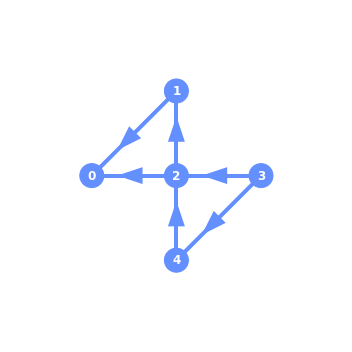

In [52]:
backend = provider.get_backend('ibmqx4')
plot_gate_map(backend, plot_directed=True)

and one that does not:

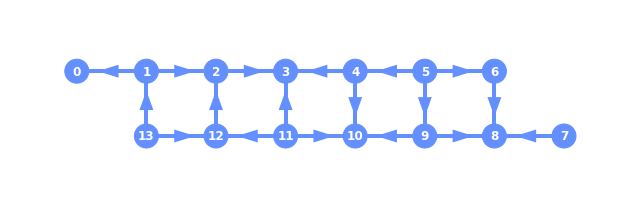

In [55]:
backend = provider.get_backend('ibmq_16_melbourne')
plot_gate_map(backend, plot_directed=True)

It seems our circuit is a good match to the `ibmqx2` and `ibmqx4` topologies provided that we map virtual qubit `0` to physical qubit `2`.  The arrows on the graphs above indicate that CNOT gates are only allowed in one direction.  However, flipping the direction of a CNOT gate is relatively trivial, and does not greatly affect the fidelity of the computation.

`ibmq_16_melbourne` represents a problem.  There is no qubit anywhere that is connected to four others via CNOT gates.  In order to implement a CNOT gate between qubits that are not directly connected, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Our choice of `initial_layout` in `job2` above was purposely designed to take many SWAP gates to make adjacent. As we have seen previously, each SWAP gate is decomposed into three CNOT gates on the IBM Q devices, and represents an expensive operation to perform.  Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device, is an important step (if not the most important) in the whole execution process.

As with many important things in life, finding the optimal SWAP mapping is hard.  In fact it is in a class of problems called NP-Hard, and is thus is prohibitively expensive to compute for all but the smallest quantum devices and input circuits.  To get around this, by default Qiskit uses a stochastic heuristic algorithm called `StochasticSwap` to compute a good, but not necessarily minimal SWAP count.  A more in depth discussion is saved for later.  However, it is important to point out that the use of a stochastic method means the circuits generated by `execute` (or other qiskit rewriting functions) are not guaranteed to be the same over repeated runs.  Indeed, running the same circuit repeatedly will in general result in a distribution of circuit depths and gate counts at the output.

## Optimizing Single- and Multi-Qubit Gates

Decomposing quantum circuits into the basis gate set of the IBM Q devices, and the addition of SWAP gates needed to match hardware topology, conspire to increase the depth and gate count of quantum circuits.  Fortunately many routines for optimizing circuits by combining or eliminating gates exist.  In some cases these methods are so effective the output circuits have lower depth than the inputs.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.